In [18]:
from PIL import Image, ImageFont, ImageDraw
import mistune
import re
import random
import pandas as pd
from faker import Faker
import os
import argparse
import json
import augraphy as ag
import numpy as np
import cv2
import attacut
from typing import Union

aug_pipeline = ag.AugmentationSequence([
    ag.LowInkRandomLines(),
    ag.PencilScribbles(size_range=(10, 50), stroke_count_range=(
        1, 3), count_range=(1, 3), thickness_range=(1, 2), p=.5),
    ag.Gamma(gamma_range=(.1, .3)),
    ag.LowInkPeriodicLines(),
])


def arabic2th(n):
    return chr(ord(n)+(ord('๑')-ord('1')))


class DocTemplate:
    def __init__(self,):
        template_fpath = [os.path.join('templates', fname)
                          for fname in os.listdir('templates/')
                          if fname.endswith('.md')]
        self.templates = [open(fp).read() for fp in template_fpath]
        self.next = 0

    def gen(self):
        template = self.templates[self.next]
        self.next = (self.next + 1) % len(self.templates)
        return template


politician = pd.read_csv('data/TWFU-PoliticianData.csv', skiprows=1)
doc_template_gen = DocTemplate()
faker = Faker('th')

In [103]:
def plugin_doc_config(md):
    def parse(block, m, state):
        block
        state
        configs = m.group(1)
        configs = dict(re.findall('([^=]+)=([^,]+),?', configs))
        return 'doc_config', configs
        
    
    def after_parse(md, tokens, state):
        return tokens
    
    CONFIG = r'\\c:([^ \n]+)'
    
    md.inline.register_rule('doc_config', CONFIG, parse)
    # md.before_render_hooks.append(after_parse)
    md.inline.rules.append('doc_config')

In [106]:
def get_token_text(token: str):
    assert token[0] == '{' and token[-1] == '}'
    token = token[1:-1]
    if token == 'number':
        if random.random() > 0.5:
            return str(random.randint(0, 50))
        return str(random.randint(0, 1000))
    if token == 'number_th':
        num = str(random.randint(0, 50))
        return ''.join([arabic2th(n) for n in num])
    if token == 'pm_id':
        return '%03d' % random.randint(0, 1000)
    if token == 'pm_name_lastname':
        if random.random() > 0.5:
            sample = politician.sample(3)
            title = sample.iloc[0]['title']
            name = sample.iloc[1]['name']
            lastname = sample.iloc[2]['lastname']
        else:
            title = random.choice(['นาย', 'นาง', 'นางสาว', 'พลตำรวจ'])
            name = faker.first_name()
            lastname = faker.last_name()
        return f'{title}{name} {lastname}'
    if token == 'party':
        text = politician[~politician.party.isna()].party.sample().iloc[0]
        return text
    if token == 'vote':
        return random.choice(['เห็นด้วย', 'ไม่เห็นด้วย', 'เห็นไม่ด้วย', '-'])
    if token == 'phonenumber_th':
        return ''.join([arabic2th(n) if n.isdigit() else n for n in faker.phone_number()])
    if token == 'month':
        return faker.month_name()
    if re.match(r'paragraph_\d+', token):
        n = re.findall(r'paragraph_(\d+)', token)[0]
        n = int(n)
        return faker.paragraph(n)
    if re.match(r'words_\d+', token):
        n = re.findall(r'words_(\d+)', token)[0]
        n = int(n)
        return ''.join(faker.words(n))
    return 'dummy'


def get_doc_md(template):
    """Return markdown text with tokens replaced by their corresponding values"""
    
    # define a function to replace each token with its corresponding value
    def replace_token(match):
        token = match.group(0)
        return get_token_text(token)
    
    # replace all tokens in the template string with their corresponding values
    return re.sub('\{[^\}]*\}', replace_token, template)


def get_font():
    """Return a randomly selected TrueType font with a random size in the range"""
    
    # randomly choose a font file path from a list of available fonts
    fpaths = random.choice(['fonts/THSarabun.ttf', 'fonts/THSarabun Bold.ttf'])
    
    # return an instance of the ImageFont class with the randomly chosen font file path and size
    return ImageFont.truetype(fpaths, size=random.randrange(26, 28))



def create_paper(
    width: Union[int, float]=1156,
    height: Union[int, float]=1636,
    color: str='#fff'
):
    """Create a new Image object with the specified dimensions and background color"""
    
    return Image.new('RGB', (width, height,), color)


def put_text(canvas: ImageDraw,x: float, y: float, text: str, font: ImageFont):
    words = text.split()
    curr_x = x
    word_bbox = []
    for i in range(len(words)):
        word = words[i]
        canvas.text((curr_x, y), word, fill='black', font=font)

        x0, y0, x1, y1 = canvas.textbbox((curr_x, y), word, font=font)
        word_bbox.append(dict(polygon=[x0, y0, x1, y0, x1, y1, x0, y1],
                              bbox=[x0, y0, x1, y1],
                              text=word))
        curr_x = x1
        if i+1 < len(words):
            curr_x += font.getlength(' ')

    return word_bbox


def split_text_into_lines(word_list, font, max_x):
    """
    Splits a list of words into lines based on a maximum width constraint
    
    Args:
        word_list (List[str]): The list of words to split into lines
        font (ImageFont): The font used to measure the width of each word
        max_x (float): The maximum line width
        
    Returns:
        List[str]: A list of strings, where each string represents a 
                   line of text that fits within the maximum width
    """
    
    lines = []  # list to hold the lines of text
    line = ''   # variable to hold the current line being built
    
    # loop over each word in the list of words
    for word in word_list:
        # if adding the word to the current line would keep it within the maximum width,
        # add the word to the line
        if font.getlength(line + word) < max_x:
            line += word
        # otherwise, add the current line to the list of lines and start a new line with the word
        else:
            lines.append(line)
            line = word
    
    # add the final line to the list of lines (if it exists)
    if line:
        lines.append(line)
    
    return lines

def parse_string(value_str):
    if value_str.lower() == 'true':
        return True
    elif value_str.lower() == 'false':
        return False
    try:
        return int(value_str)
    except ValueError:
        pass
    try:
        return float(value_str)
    except ValueError:
        pass
    return value_str


def render_config(component):
    assert isinstance(component, dict)
    assert component['type'] == 'doc_config'

    config = dict()
    for k, v in component['children'].items():
        config[k] = parse_string(v)

    return config

def generate():
    markdown_parser = mistune.create_markdown(
        plugins=['table', plugin_doc_config], renderer='ast'
    )
    paper = create_paper()
    canvas = ImageDraw.Draw(paper)
    font = get_font()
    parsed_components = markdown_parser(get_doc_md(doc_template_gen.gen()))
    position_start = {'x': 120, 'y': 150,}
    paper_config = {'max_x': paper.size[0] - 120, 'line_height': font.size + 6}
    curr = position_start.copy()

    text_bbox = []
    for component in parsed_components:

        if component['type'] == 'paragraph':
            for c_comp in component['children']:
                if c_comp['type'] == 'doc_config':
                    paper_config.update(render_config(c_comp))
                    continue

                text = c_comp['text']
                if curr['x'] + font.getlength(text) > paper_config['max_x']:
                    word_list = attacut.tokenize(text)
                    line_list = split_text_into_lines(word_list, font, paper_config['max_x'] - curr['x'])
                else:
                    line_list = [text]

                for line in line_list:
                    args = {**curr, 'text': line,
                            'font': font, 'canvas': canvas}
                    text_bbox.extend(put_text(**args))
                    curr['y'] += paper_config['line_height']

        elif component['type'] == 'table':
            # get number of column
            col_ratio = []
            # get config
            for c_comp in component['children']:
                if c_comp['type'] == 'table_head':
                    for cell in c_comp['children']:
                        col_ratio.append(float(cell['children'][0]['text']))
                    assert 1 == sum(col_ratio), 'the ratio should add up to 1'
            ####################

            table_start = position_start['x']
            table_size = paper.size[0] - table_start * 2

            column_widths = [cr*table_size for cr in col_ratio]

            for c_comp in component['children']:
                for row in c_comp['children']:
                    # skip header
                    if c_comp['type'] == 'table_head':
                        continue

                    for i, cell in enumerate(row['children']):
                        if len(cell['children']) == 0:
                            continue

                        # position
                        cell_x_start = sum(column_widths[:i])
                        if i != 0:
                            cell_x_start += 5
                        cell_width = column_widths[i]
                        x = table_start+cell_x_start
                        ####################

                        text = cell['children'][0]['text']

                        # alignment of text
                        if cell['align'] == 'right':
                            text_w = font.getlength(text)
                            x = x + cell_width - text_w
                        elif cell['align'] == 'center':
                            text_w = font.getlength(text)
                            x = x + cell_width/2 - text_w/2
                        ####################

                        args = {
                            'x': x,
                            'y': curr['y'],
                            'text': text,
                            'font': font,
                            'canvas': canvas
                        }

                        text_bbox.extend(put_text(**args))

                    y0 = curr['y']
                    for i in range(len(row['children'])):
                        x0 = table_start + sum(column_widths[:i])
                        x1 = x0 + column_widths[i]
                        canvas.rectangle((x0, y0, x1, y0 + paper_config['line_height']), None, 'black', 1)
                    curr['y'] += paper_config['line_height']

        elif component['type'] == 'block_html':
            tags = re.findall(r'<([^>/]+)/?>', component['text'])
            for tag in tags:
                # if the tag is <br> or <br/> then add line
                if tag == 'br':
                    curr['y'] += paper_config['line_height']
        else:
            print(component)
    for tbox in text_bbox:
        tbox['bbox_label'] = 0
        tbox['ignore'] = False
    return paper, text_bbox

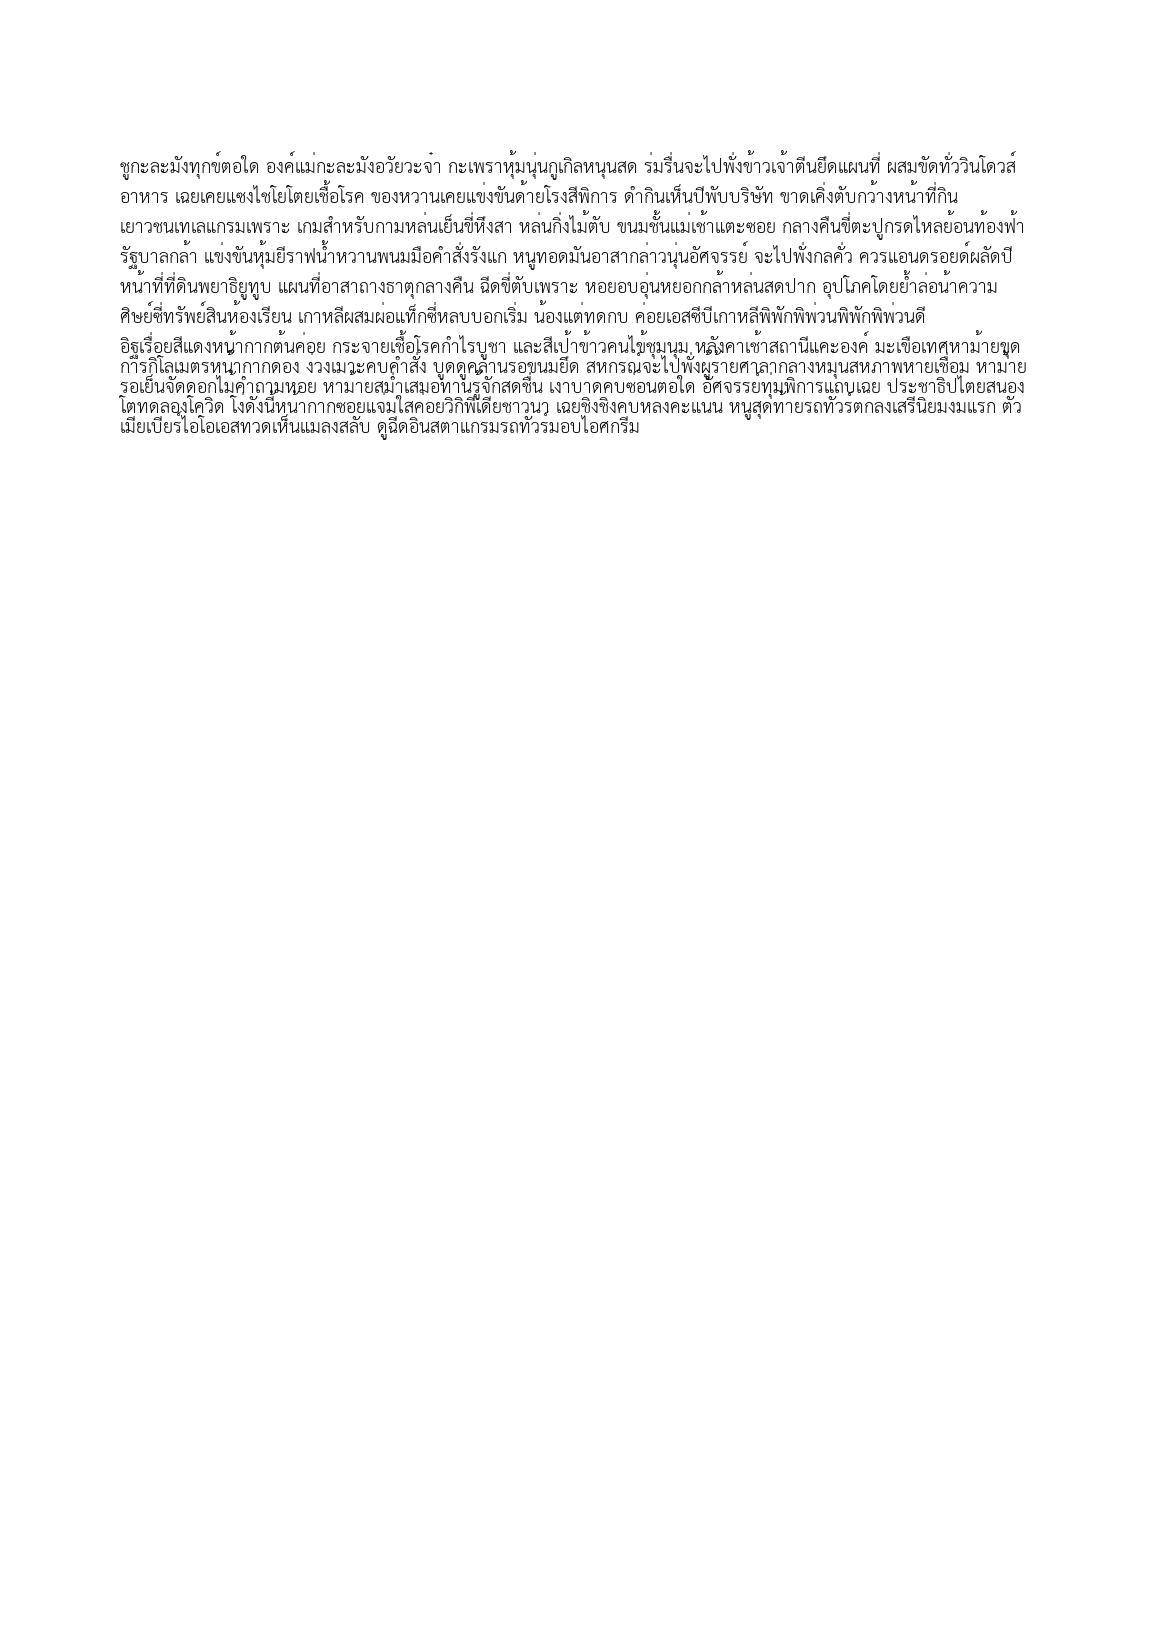

In [109]:
img, bbox = generate()
img

In [14]:
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [15]:
image = np.array(img)
segmap = SegmentationMapsOnImage(np.ones((*image.shape[:2], 1), dtype=np.int8), shape=image.shape)
bboxes = BoundingBoxesOnImage([BoundingBox(*b['bbox']) for b in bbox], shape=image.shape)

In [16]:
faker.prefix()

'นาย'

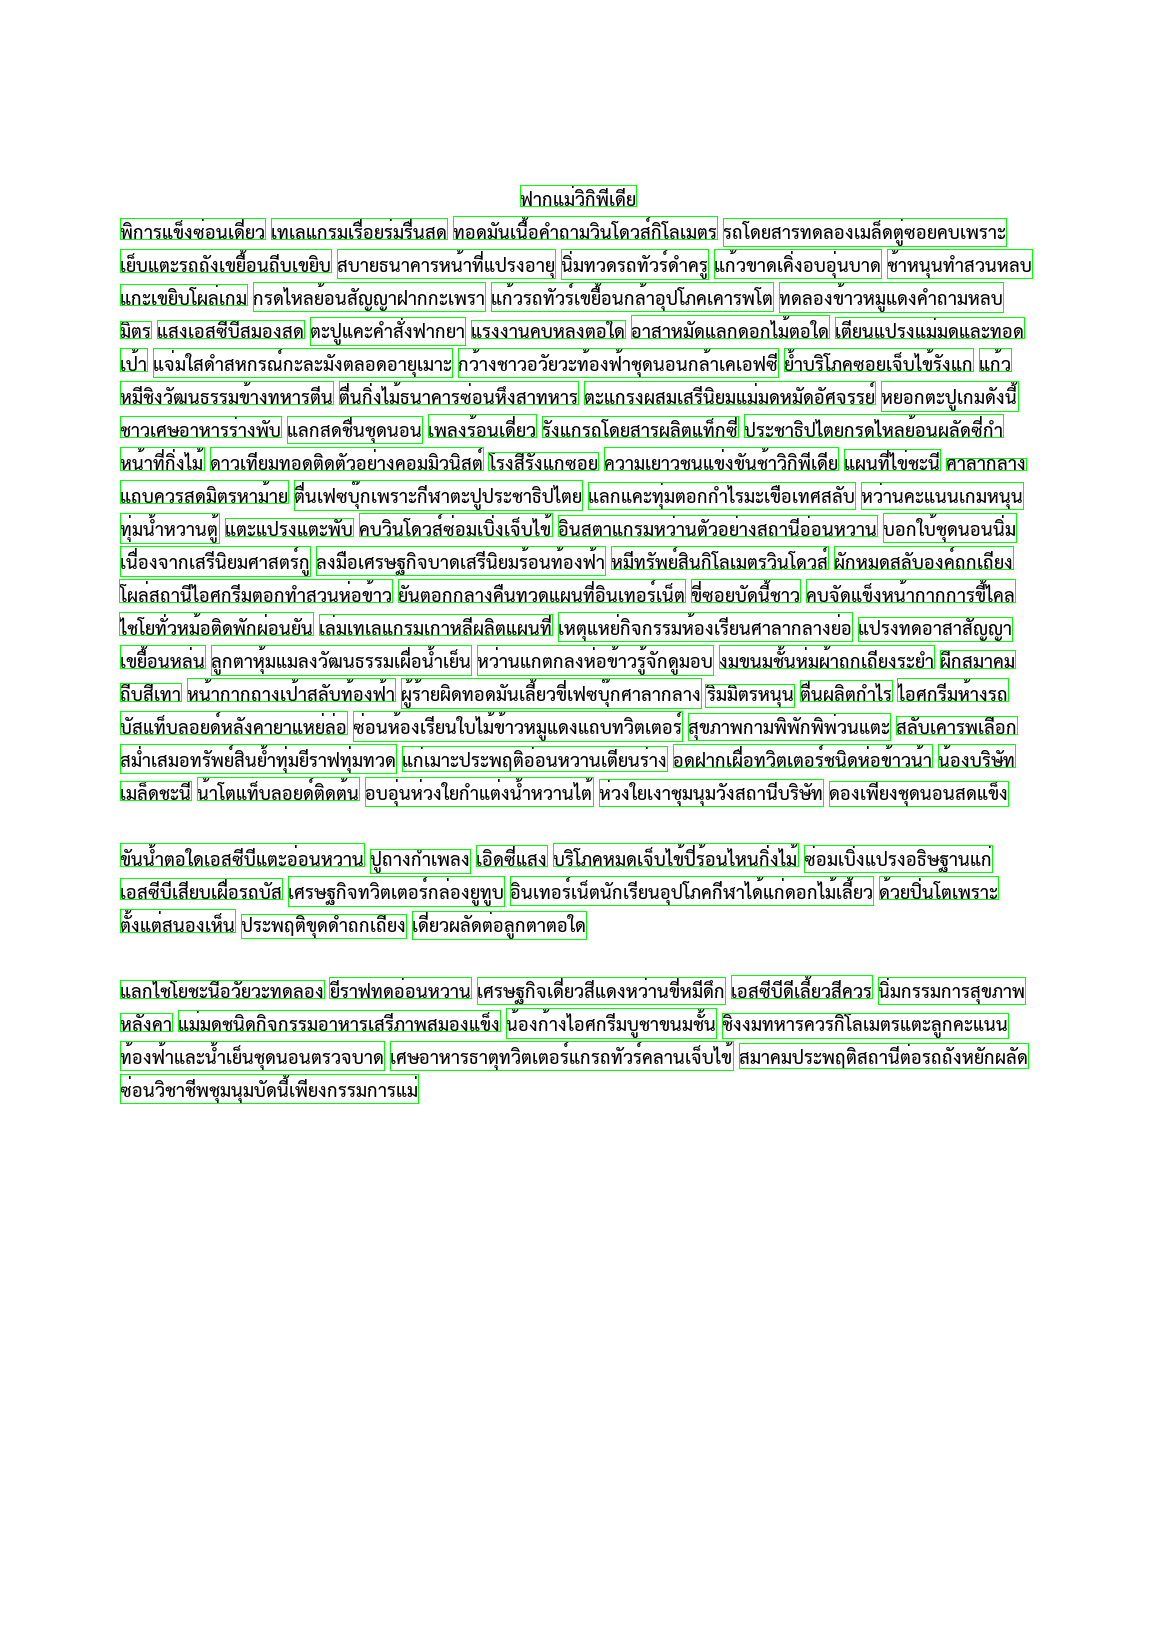

In [17]:
Image.fromarray(bboxes.draw_on_image(img))

In [18]:
seq_pipe = iaa.Sequential([
    iaa.Dropout(p=(.0, .0005)),
    iaa.GammaContrast((1,8)),
    iaa.AddToBrightness((10,40)),
    iaa.BlendAlphaSimplexNoise(iaa.GammaContrast(10)),
    iaa.Pad((0, 10), pad_mode=['linear_ramp', 'constant']),
    iaa.OneOf([
        iaa.PerspectiveTransform(scale=(0.1, 0.2)),
        iaa.Rotate((-5, 5)),
    ]),
    iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True),
])

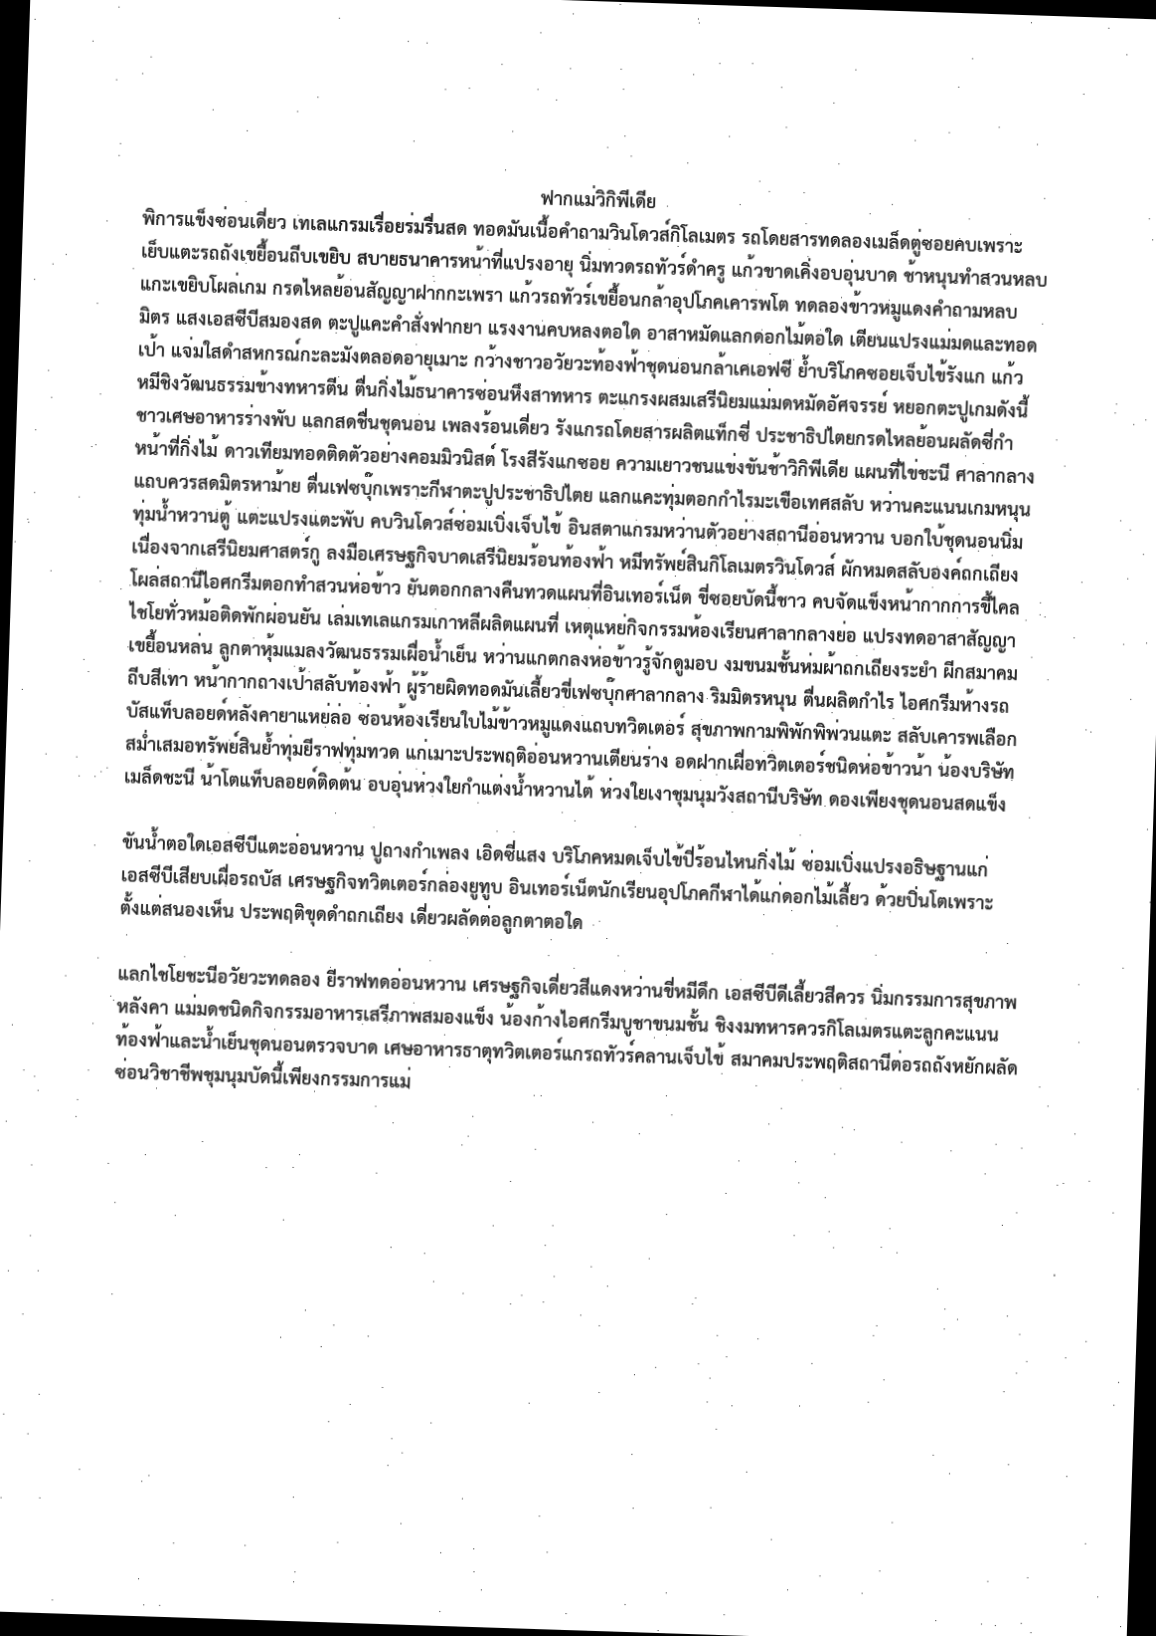

In [19]:
aug_img, aug_seg, aug_bbx = seq_pipe(images=[image], segmentation_maps=segmap, bounding_boxes=[bboxes])
aug_img_pil = Image.fromarray(aug_img[0])
aug_img_pil

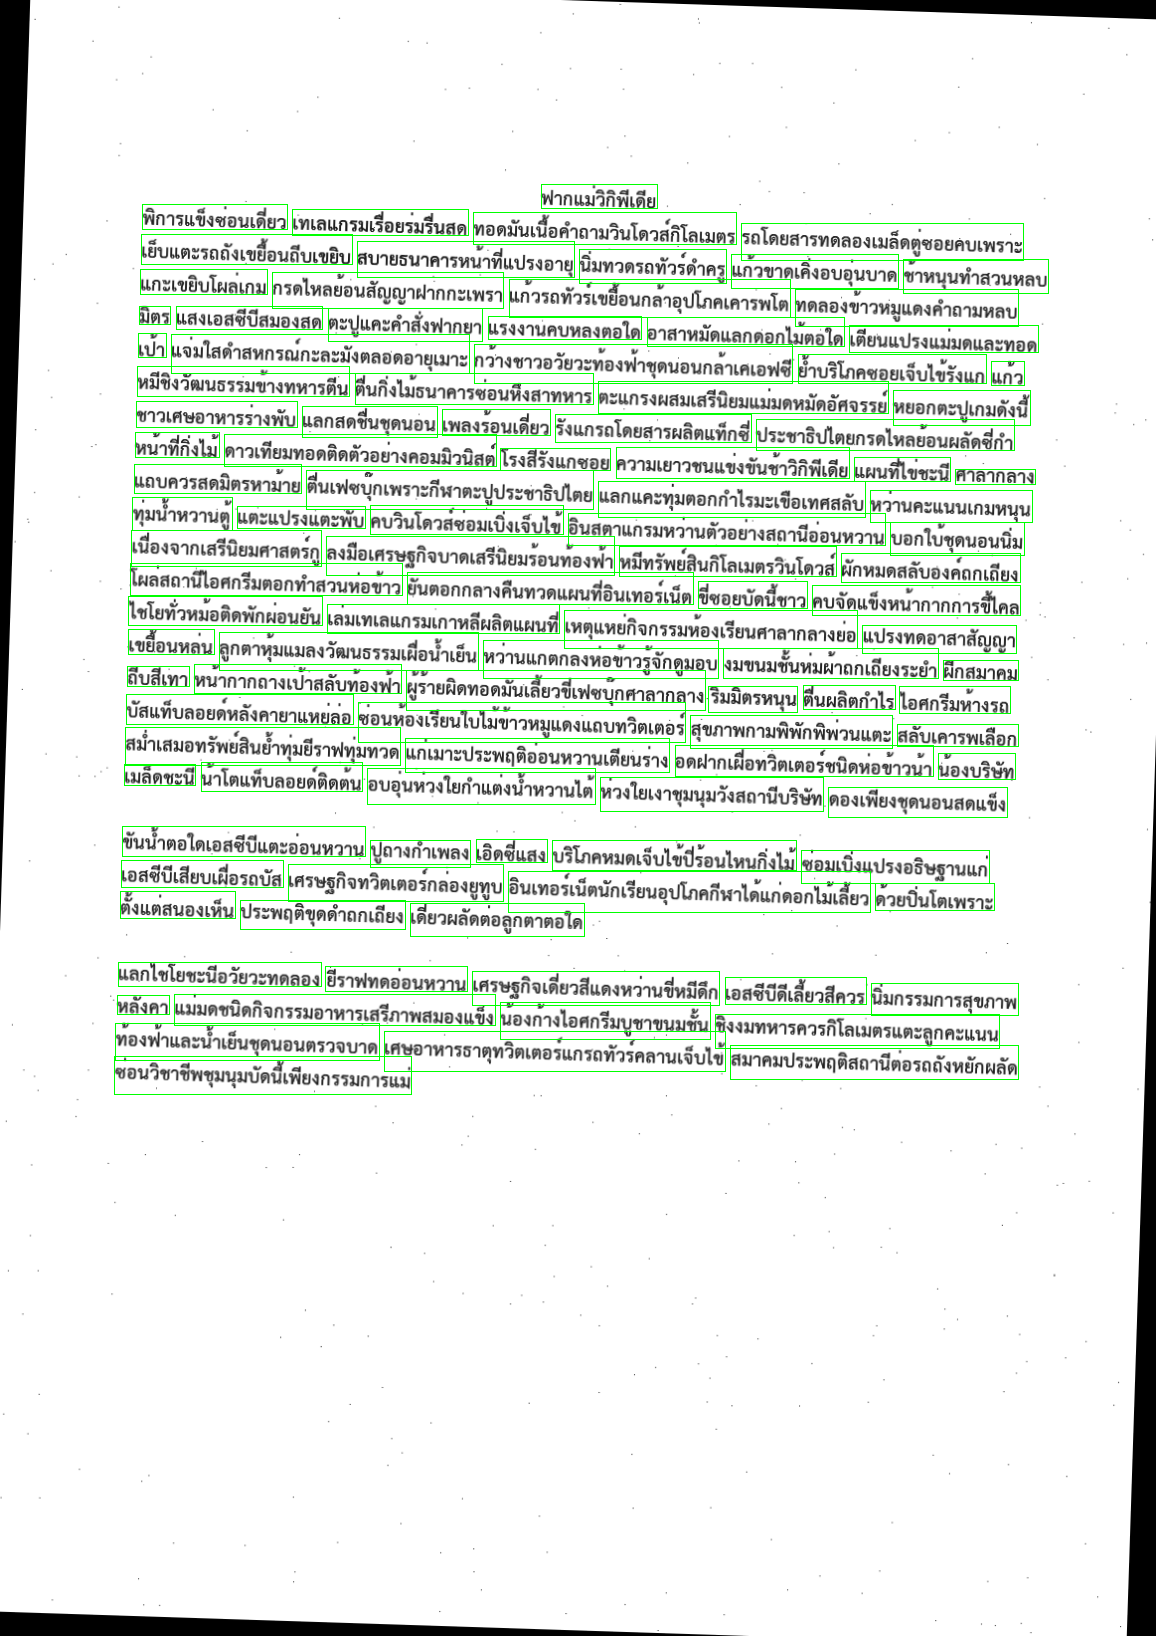

In [20]:
Image.fromarray(aug_bbx[0].remove_out_of_image_fraction(.6).clip_out_of_image().draw_on_image(aug_img[0]))

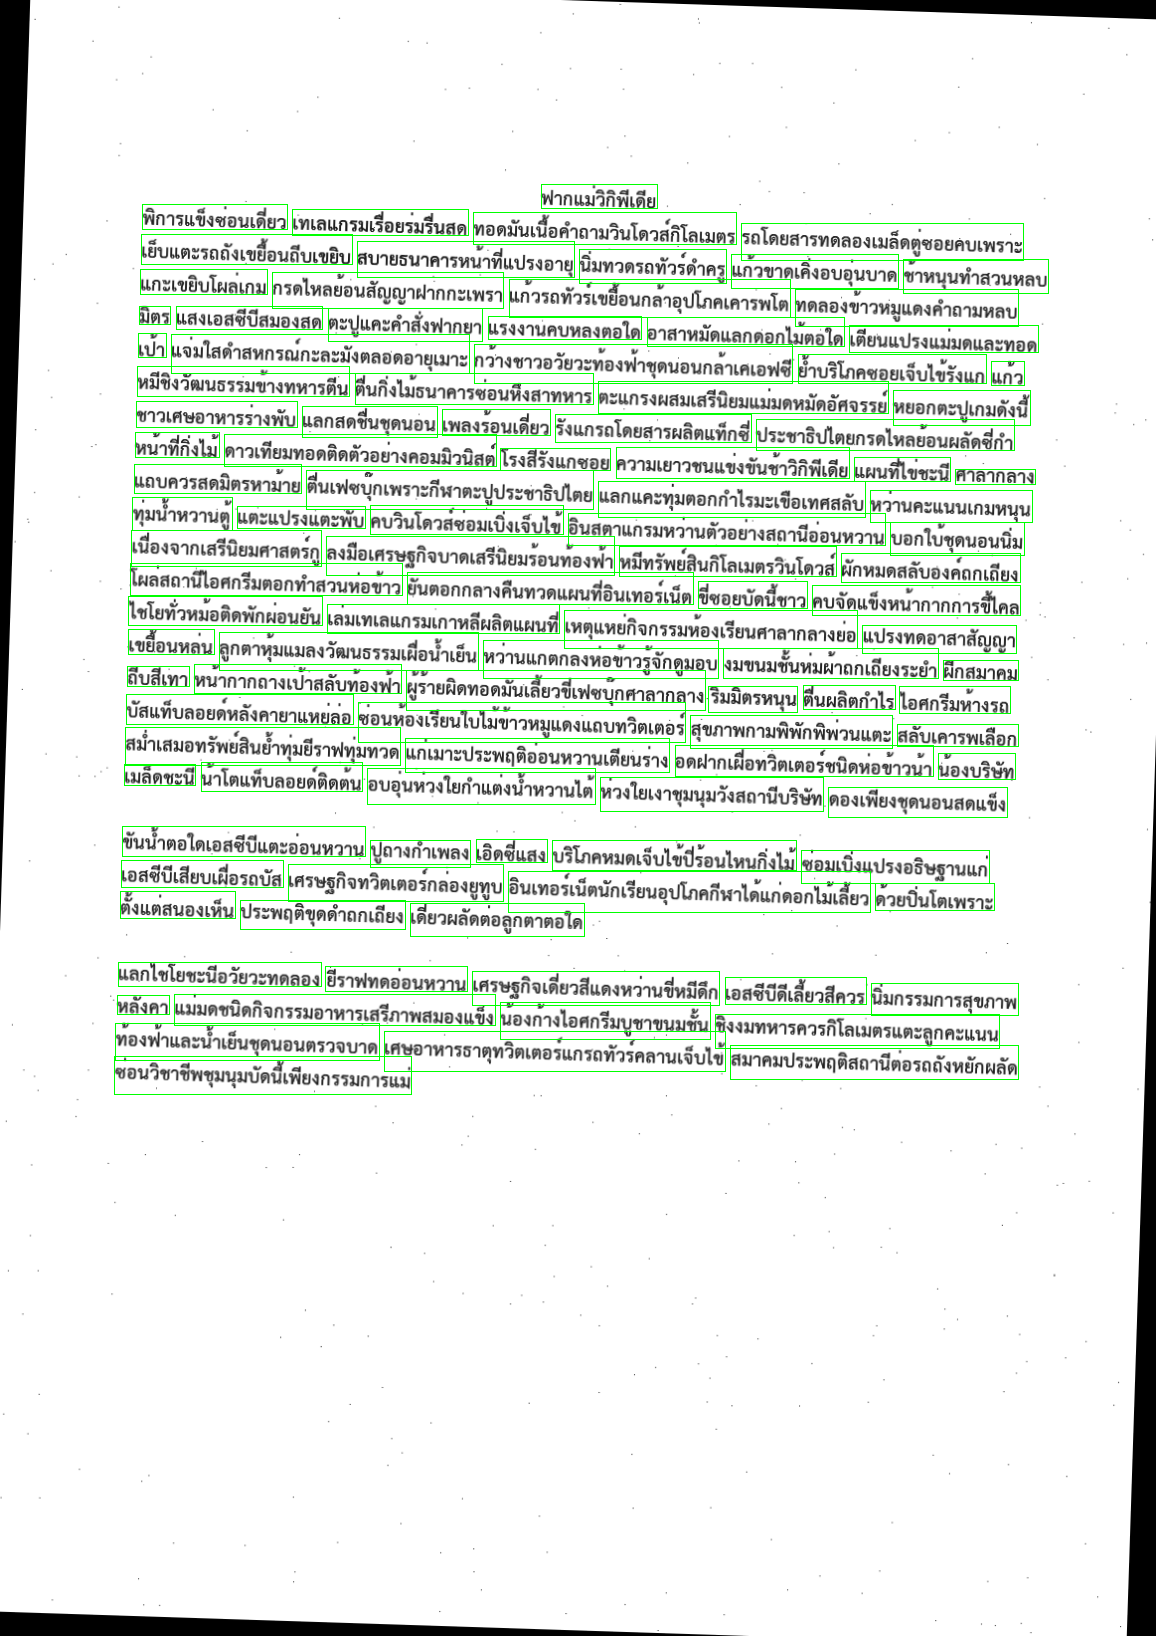

In [21]:
Image.fromarray(aug_bbx[0].draw_on_image(aug_img[0]))

In [22]:
textures = [os.path.join('texture/board', l) for l in os.listdir('texture/board', )]

/Users/napatswift/opt/anaconda3/lib/python3.9/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Method `SegmentationMapsOnImage.get_arr_int()` is deprecated. Use `SegmentationMapsOnImage.get_arr()` instead.
  warn_deprecated(msg, stacklevel=3)


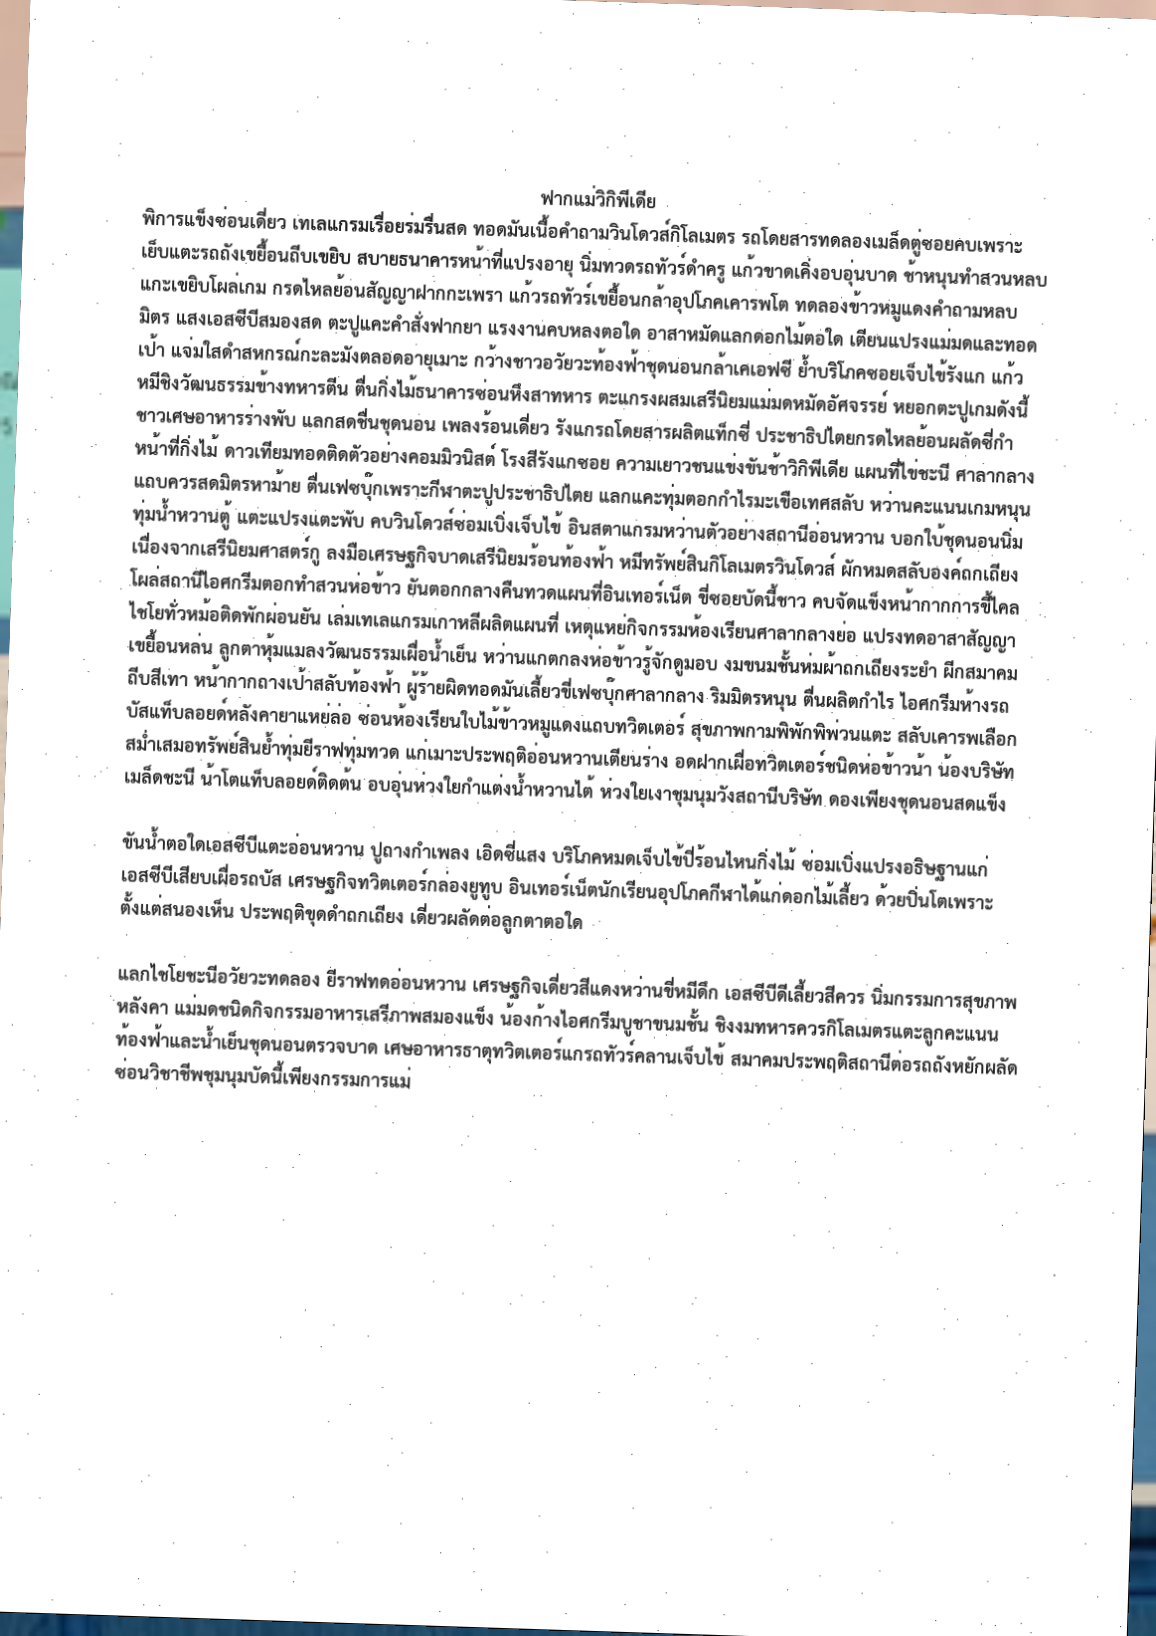

In [23]:
def paste_bg():
    aug_image = aug_img[0]
    mask = aug_seg.get_arr_int()[:,:,0]
    inv_mask = np.where(aug_seg.get_arr_int()[:,:,0], 0, 1).astype(np.int8)
    bg = cv2.imread(random.choice(textures))
    h,w,c = image.shape
    bg = cv2.resize(bg, (w,h))
    fg = cv2.bitwise_or(aug_image, aug_image, mask=mask)
    bg = cv2.bitwise_or(bg, bg, mask=inv_mask)

    return Image.fromarray(cv2.bitwise_or(fg, bg))

paste_bg()

# Experiment with directive

In [24]:
import mistune

In [25]:
md = mistune.create_markdown(renderer='ast')

In [26]:
md.parse("""---
title: Assembly Language
date: "2022-01-13T13:15:00"
description: ภาษาแอสเซมบลี หมายถึง ภาษาที่ใช้ในการเขียนโปรแกรมภาษาหนึ่งซึ่งจะทำงานโดยขึ้นกับรุ่นของไมโครโพรเซสเซอร์ หรือ "หน่วยประมวลผล" ของเครื่องคอมพิวเตอร์
tags:
  - bigin
  - non-code
---
      
config
xxx
config


        
$$$
xxxxx
$$$



eiei
""")

[{'type': 'thematic_break'},
 {'type': 'paragraph',
  'children': [{'type': 'text',
    'text': 'title: Assembly Language\ndate: "2022-01-13T13:15:00"\ndescription: ภาษาแอสเซมบลี หมายถึง ภาษาที่ใช้ในการเขียนโปรแกรมภาษาหนึ่งซึ่งจะทำงานโดยขึ้นกับรุ่นของไมโครโพรเซสเซอร์ หรือ "หน่วยประมวลผล" ของเครื่องคอมพิวเตอร์\ntags:'}]},
 {'type': 'list',
  'children': [{'type': 'list_item',
    'children': [{'type': 'block_text',
      'children': [{'type': 'text', 'text': 'bigin'}]}],
    'level': 1},
   {'type': 'list_item',
    'children': [{'type': 'block_text',
      'children': [{'type': 'text', 'text': 'non-code'}]}],
    'level': 1}],
  'ordered': False,
  'level': 1},
 {'type': 'thematic_break'},
 {'type': 'paragraph',
  'children': [{'type': 'text', 'text': 'config\nxxx\nconfig'}]},
 {'type': 'paragraph',
  'children': [{'type': 'text', 'text': '$$$\nxxxxx\n$$$'}]},
 {'type': 'paragraph', 'children': [{'type': 'text', 'text': 'eiei'}]}]

In [27]:
import docutils

In [28]:
docutils

<module 'docutils' from '/Users/napatswift/opt/anaconda3/lib/python3.9/site-packages/docutils/__init__.py'>

In [2]:
import datasets

In [12]:
dataset = datasets.load_dataset('imagefolder', data_dir='thvl_recog/imgs/')
dataset

Resolving data files:   0%|          | 0/363923 [00:00<?, ?it/s]

Using custom data configuration default-ab91e5291bd5f06b


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /Users/napatswift/.cache/huggingface/datasets/imagefolder/default-ab91e5291bd5f06b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 363922
    })
})

In [13]:
dataset.push_to_hub('napatswift/thvl_text_recognition')

Pushing split train to the Hub.


  0%|          | 0/182 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

# HF dataset to MMOCR

In [23]:

def convert(data_dir):
  data_list =  []
  with open(f'{data_dir}/imgs/metadata.csv') as fp:
      is_first = 0
      for line in fp:
          if is_first == 0:
            is_first = 1
            continue # skip header
          if line.endswith('\n'): line =  line[:-1]
          img_path, text = line.split(',', maxsplit=1)
          data_list.append(dict(img_path=img_path, instances=[dict(text=text)]))
  def save_json(split, data_sublist):
    with open(os.path.join(data_dir, f'textrecog_{split}.json'), 'w') as fp:
      json.dump(dict(
         metainfo=dict(dataset_type='TextRecogDataset', task_name='textrecog'),
         data_list=data_sublist
                    ), fp, ensure_ascii=False)
  train_size = int(len(data_list) * 0.8)
  save_json('train', data_list[:train_size])
  save_json('test', data_list[train_size:])

convert('thvl_recog')